# Import libraries

In [1]:
import os
import sys
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()

In [2]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Load Sumstats

In [3]:
disease = "ms"
scenario = "abyss"
max_maf = 0.5
min_maf = 0
logp_min = 6
logp_max = 100
P_cutoff = 5e-8
PCs = 15
nr_snps = 3000
bin =5

In [4]:
path_input = glob.PATH_GENO + f"/03_summary_statistics/{disease}/{scenario}"

In [5]:
list_of_bins = os.listdir(path_input)

In [6]:
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

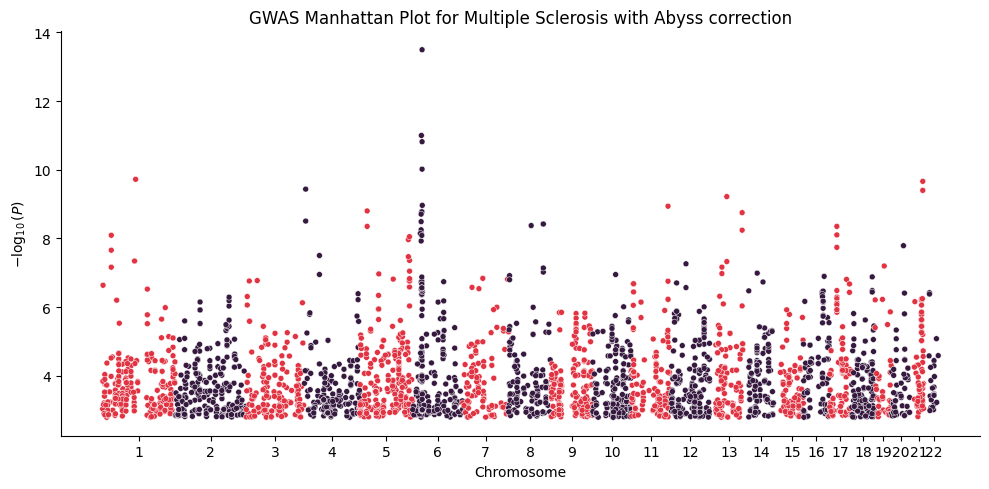

In [7]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Find geno and mafs for selected SNPs

In [8]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,cumulative_pos,SNP number,color
26539,1:232925406:C_T_T,-4.657920,-0.021947,5.512662,0.010186,-2.154565,0.031297,1,232925406,3.464247,5,232925406,26539,"(0.20973515, 0.09747934, 0.24238489)"
37799,1:44426948:A_G_A,5.539170,-0.021770,-5.378695,0.009921,-2.194190,0.028319,1,44426948,3.564233,5,44426948,37799,"(0.20973515, 0.09747934, 0.24238489)"
18971,1:167259336:A_T_A,16.480471,0.026007,-17.363882,0.010189,2.552521,0.010757,1,167259336,4.532201,5,167259336,18971,"(0.20973515, 0.09747934, 0.24238489)"
41893,1:108113702:A_G_G,-6.639279,0.021542,7.653381,0.010460,2.059447,0.039561,1,108113702,3.229920,5,108113702,41893,"(0.20973515, 0.09747934, 0.24238489)"
33117,1:87854436:A_G_A,5.563484,0.025589,-5.442605,0.010031,2.550981,0.010804,1,87854436,4.527793,5,87854436,33117,"(0.20973515, 0.09747934, 0.24238489)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38719,22:43642153:C_T_T,-6.572149,0.028311,7.602910,0.010334,2.739617,0.006197,22,43642153,5.083648,5,2837211665,38719,"(0.8833417, 0.19830556, 0.26014181)"
45520,22:44705240:A_G_G,-17.800478,-0.021162,19.790469,0.010274,-2.059712,0.039535,22,44705240,3.230561,5,2838274752,45520,"(0.8833417, 0.19830556, 0.26014181)"
32920,22:21404113:A_G_A,-6.307436,-0.019732,7.363447,0.010070,-1.959504,0.050171,22,21404113,2.992316,5,2814973625,32920,"(0.8833417, 0.19830556, 0.26014181)"
9215,22:23723050:A_G_A,9.846214,0.025415,-10.032593,0.010363,2.452461,0.014260,22,23723050,4.250293,5,2817292562,9215,"(0.8833417, 0.19830556, 0.26014181)"


In [9]:
unique_bins = list(sumstat['bin'].unique())

In [10]:
genos = []
mafs = []

# Iterate over unique bins
for unique_bin in unique_bins:
    # Filter sumstat for the current bin
    temp_sumstat = sumstat[sumstat['bin'] == unique_bin]

    # Construct path for genotype mapping
    path_geno_mapping = os.path.join(glob.PATH_GENO, f"01_LD_blocks/{PCs}_PCs/bin_{unique_bin}")
    
    # Load mapping data
    map_file = os.path.join(path_geno_mapping, "mapping.pkl")
    map = pd.read_pickle(map_file)
    map.rename(columns={'Position': 'POS'}, inplace=True)
    map['POS'] = map['POS'].astype(int)

    # Get path for MAF dimensions
    path_dims_of_maf = os.path.join(glob.PATH_GENO, f"02_MAF_probability_landscape/{disease}/bin_{unique_bin}")
    dims_of_maf = os.listdir(path_dims_of_maf)[0]
    path_maf = os.path.join(path_dims_of_maf, dims_of_maf)

    # Merge sumstat with mapping data
    temp_sumstat = pd.merge(temp_sumstat, map[['POS','Chromosome','Alls2', 'path']], on='POS', how='inner')
    
    # Process each unique path
    unique_paths = temp_sumstat['path'].unique()
    for path in unique_paths:
        temp2_sumstat = temp_sumstat[temp_sumstat['path'] == path]
        SNPS = temp2_sumstat['snp'].tolist()
        file_with_snp = next(f for f in os.listdir(path_geno_mapping) if f.startswith(path))
        path_file_genos = os.path.join(path_geno_mapping, file_with_snp)
        path_file_maf = os.path.join(path_maf, file_with_snp)
        geno = pd.read_pickle(path_file_genos)[SNPS]
        temp = geno.T
        temp['snp'] = list(temp.index)
        temp = pd.merge(temp, sumstat[['cumulative_pos','snp']], on='snp', how='inner')
        temp = temp.set_index('snp')
        geno = temp.T
        genos.append(geno)
        
        maf = pd.read_pickle(path_file_maf)[SNPS]
        temp = maf.T
        temp['snp'] = list(temp.index)
        temp = pd.merge(temp, sumstat[['cumulative_pos','snp']], on='snp', how='inner')
        temp = temp.set_index('snp')
        maf = temp.T
        mafs.append(maf)

In [11]:
combined_geno = pd.concat(genos, axis=1)

In [12]:
combined_maf = pd.concat(mafs, axis=1)

In [13]:
combined_geno

snp,1:232925406:C_T_T,1:68237279:A_G_G,1:232908753:C_T_C,2:33464066:A_G_G,9:112271779:A_G_A,10:102631043:A_G_A,10:36171926:A_C_A,10:132139574:C_T_T,11:91320978:C_T_C,11:73611349:C_G_G,...,9:105228941:C_T_T,9:29267427:C_T_T,12:113687859:A_G_A,14:20837033:C_T_T,16:65252673:A_G_G,18:53756180:G_T_T,5:133638156:G_T_T,13:21729226:C_T_C,15:54578561:A_G_A,20:54966146:A_C_A
0,1,1,1,1,1,1,1,1,0,1,...,1,1,0,0,1,1,1,1,1,0
1,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,0,1,1,1,1,1
2,1,0,1,1,0,0,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
3,1,1,1,1,1,1,0,1,0,0,...,1,1,1,1,1,0,1,0,1,1
4,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69451,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
69452,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
69453,1,1,1,1,1,1,1,1,0,1,...,1,-1,1,1,1,1,1,1,0,1
69454,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [14]:
path_output = glob.PATH_GENO + "/04_low_P_snps/"
os.makedirs(path_output, exist_ok = True)
combined_geno.to_pickle(path_output+"low_p_geno.pkl")
combined_maf.to_pickle(path_output+"low_p_maf.pkl")
